In [1]:
import numpy as np
import matplotlib.pyplot as plt
from lbg_forecast import emulator as em

In [2]:
bands = ["u","g","r","i","z","y"]

loss_bands = []
val_bands = []

for band in bands:
    loss = np.load("trained_models/loss_lsst_"+band+".npy")
    val = np.load("trained_models/valloss_lsst_"+band+".npy")

    loss_bands.append(loss)
    val_bands.append(val)

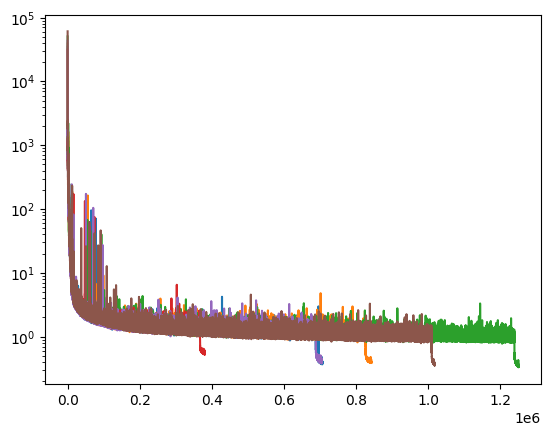

In [3]:
for x in loss_bands:
    plt.plot(x)

plt.yscale("log")

0.39411497116088867
0.3906821608543396
0.33844006061553955
0.5337325930595398
0.39268139004707336
0.3630748689174652


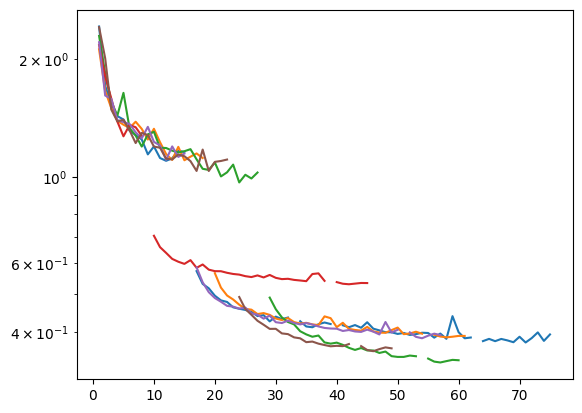

In [4]:
for y in val_bands:
    plt.plot(y)
    print(y[-1])

plt.yscale("log")

In [5]:
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [8]:
sps_params_train = np.load("training_data/sps_parameters_51000000.npy")
phot_train = np.load("training_data/photometry_51000000.npy")
phot_train[:10, :]

array([[ 29.75678959,  28.12467694,  24.70015701,  22.82596194,
         22.39992023,  22.23689741],
       [ 60.89035853,  62.96286194,  63.85536943,  57.36830225,
         53.9489629 ,  51.517151  ],
       [ 43.74367257,  44.68674064,  39.50330438,  37.20680209,
         35.99343678,  35.31727539],
       [101.68950594, 105.71303758, 113.03328381, 106.16262707,
        105.77693971,  88.83247698],
       [ 61.65872536,  63.69974675,  60.93690077,  56.24068714,
         53.86330855,  52.86069152],
       [ 76.3341553 ,  79.00158026,  82.38502927,  78.96384009,
         78.50838069,  65.89649231],
       [ 48.35166802,  50.40761148,  48.37299673,  43.23567461,
         40.85205201,  39.27746556],
       [ 45.01657123,  47.07453335,  46.50290717,  40.36182139,
         37.5986772 ,  35.86547279],
       [155.19919741, 162.78811096, 179.410706  , 165.4838679 ,
        165.09817878, 135.22905913],
       [190.67747334, 190.67737879, 190.67743413, 190.67781018,
        190.67685099, 190.6

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])


Text(0, 0.5, '$\\Delta m$')

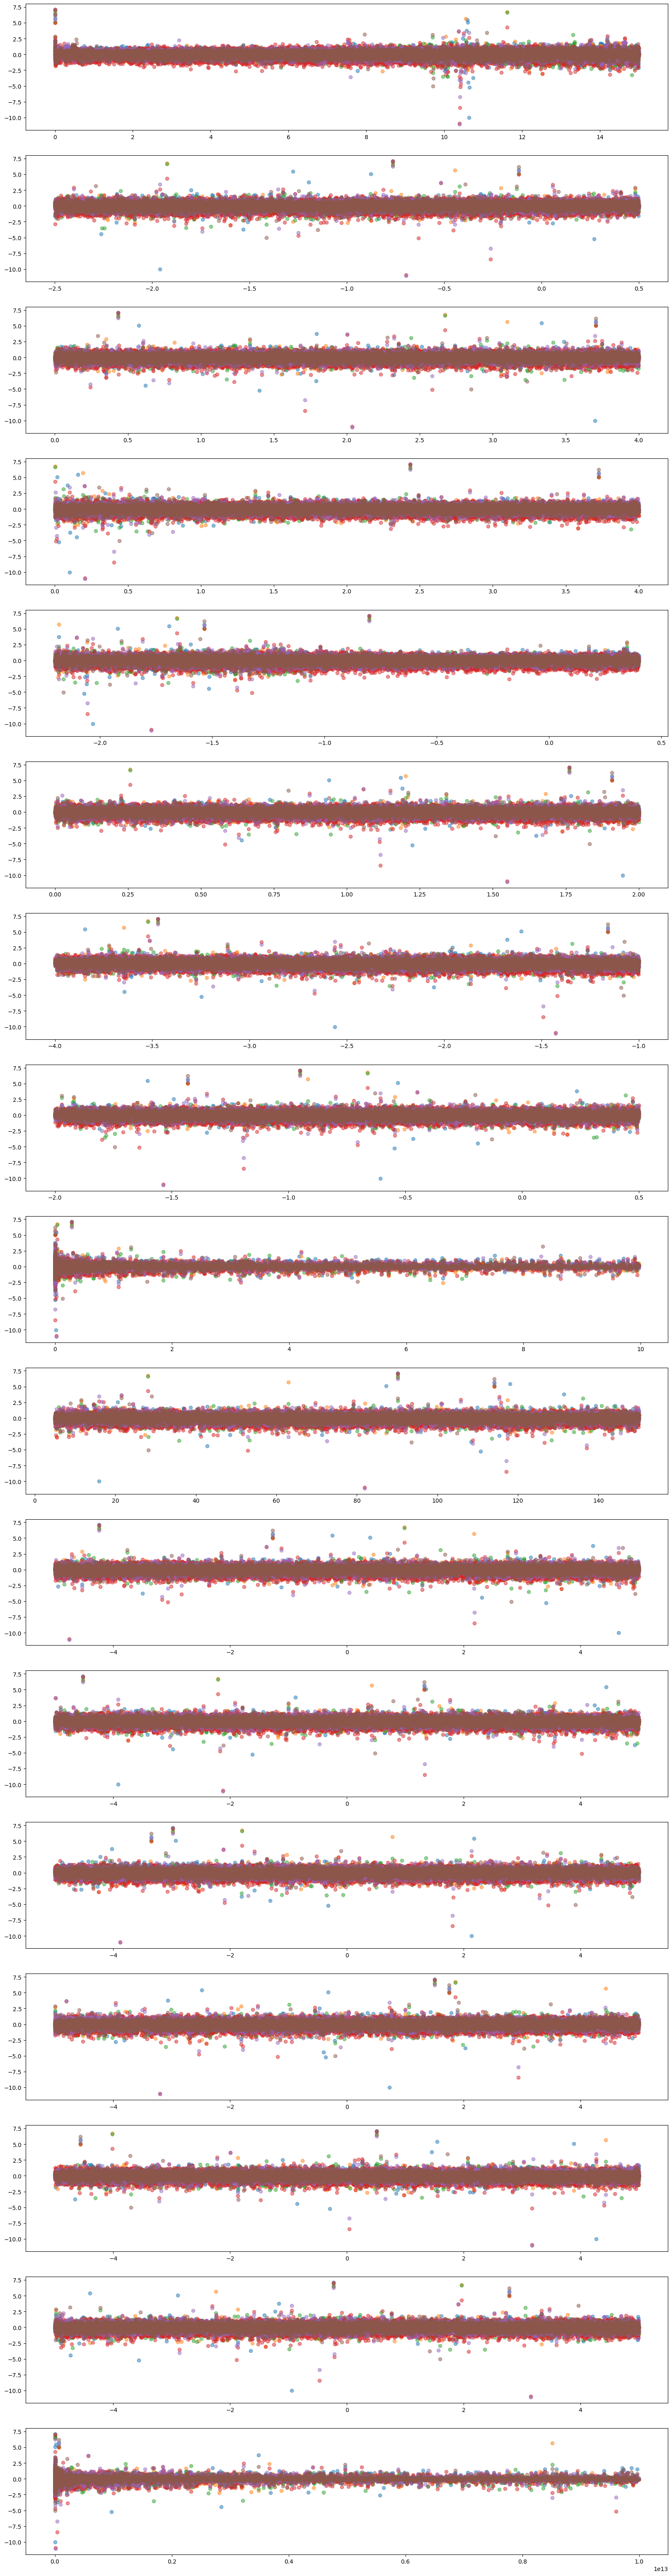

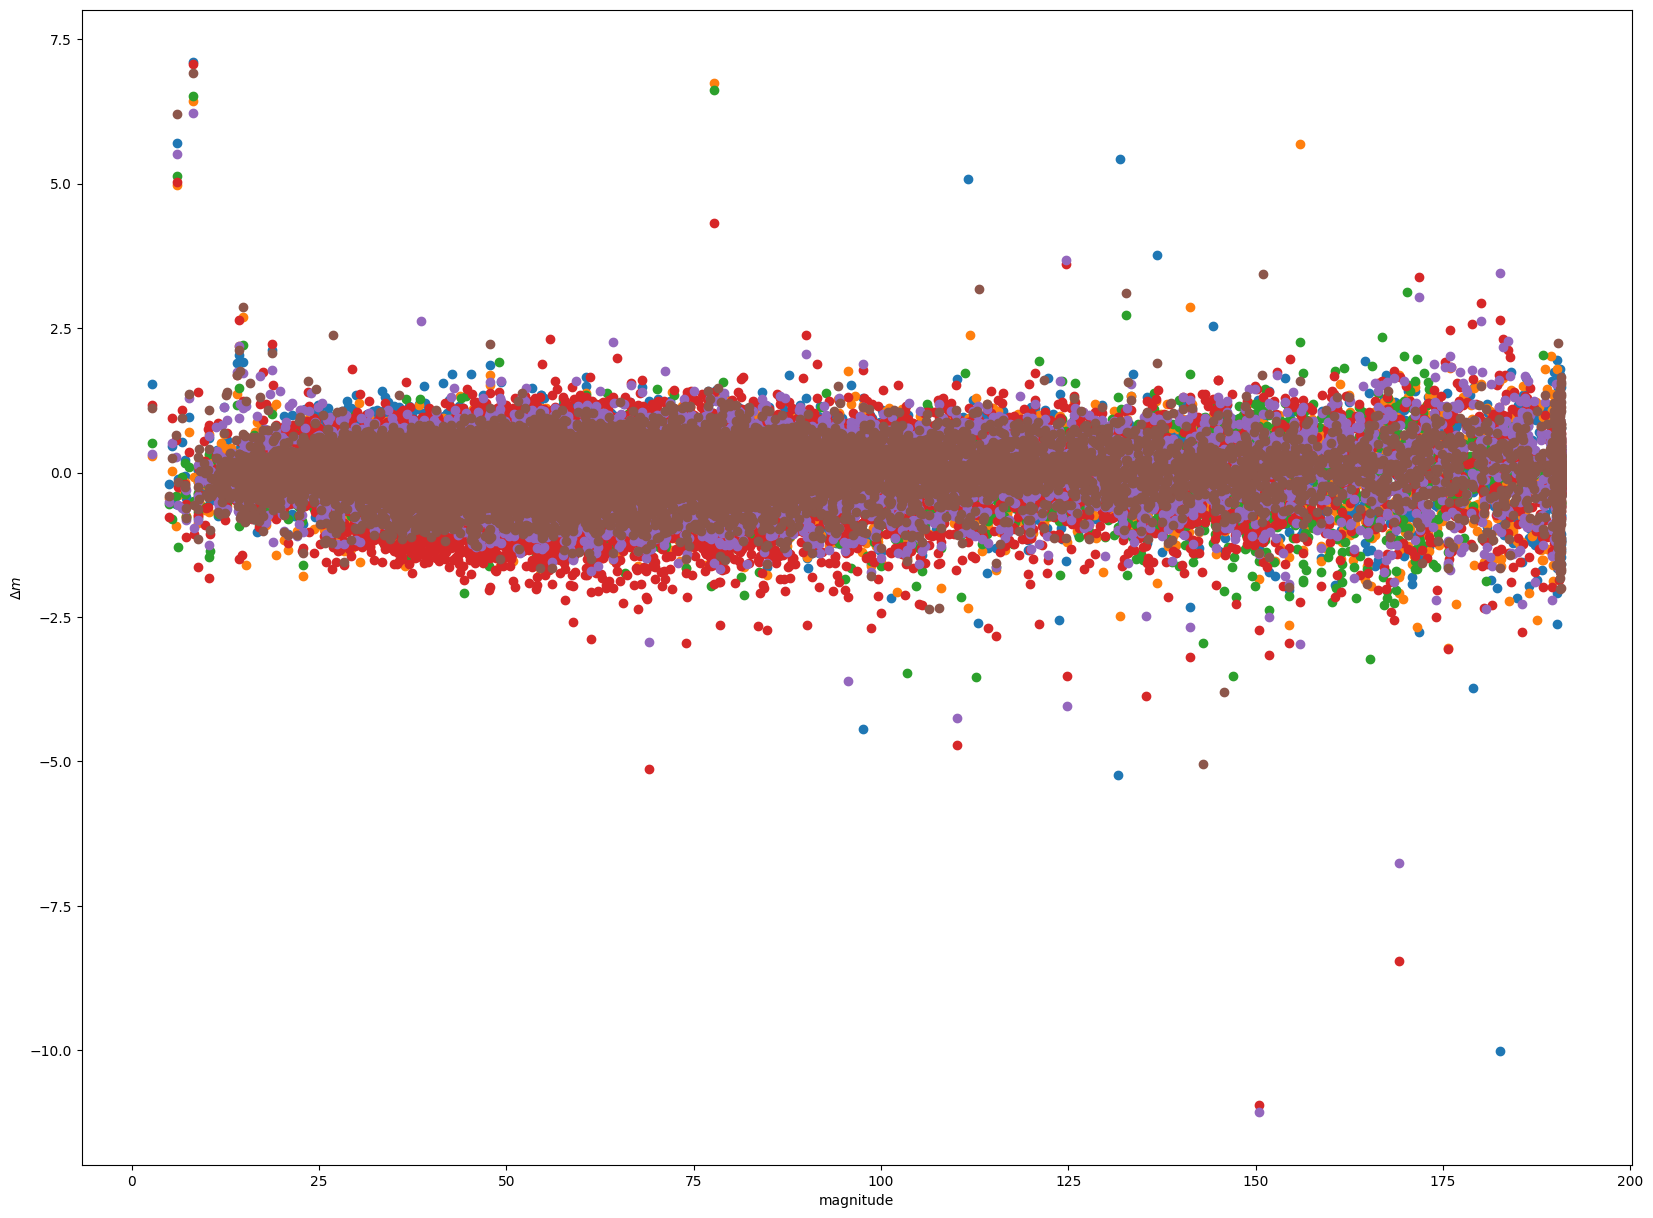

In [37]:
nsamples=20000
band = 3
sps_params = sps_params_train[:nsamples, :]
m_true = phot_train[:nsamples, :]
m_mimic = model.mimic_photometry(sps_params_train[:nsamples,:])

dm = np.hsplit(m_mimic-m_true, 6)

fig1, axes = plt.subplots(sps_params.shape[1], 1, figsize=(20,80), sharex=False, sharey=False)
alpha = 0.5
for i in range(sps_params.shape[1]):
    axes[i].scatter(sps_params[:, i], dm[0], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[1], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[2], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[3], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[4], alpha=alpha)
    axes[i].scatter(sps_params[:, i], dm[5], alpha=alpha)

fig2, axes2 = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)


axes2.scatter(m_true[:, band], dm[0])
axes2.scatter(m_true[:, band], dm[1])
axes2.scatter(m_true[:, band], dm[2])
axes2.scatter(m_true[:, band], dm[3])
axes2.scatter(m_true[:, band], dm[4])
axes2.scatter(m_true[:, band], dm[5])
axes2.set_xlabel('magnitude')
axes2.set_ylabel('$\Delta m$')


In [60]:
len(np.where(phot_train[:, 5] > 40)[0])/len(phot_train[:, 0])

0.5878970980392156